In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import seaborn as sns # for plot visualization
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf

import os
print(os.listdir("data"))


['.DS_Store', 'data.csv', 'testset.csv']


In [41]:
weather_df = pd.read_csv('data/testset.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [45]:
len(weather_df)
weather_df.columns


Index(['condition', 'humidity', 'temprature'], dtype='object')

In [43]:
weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})
print(f'dataset shape (rows, columns) - {weather_df.shape}')
weather_df.head()


dataset shape (rows, columns) - (100990, 3)


,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0


In [44]:
weather_df.columns


Index(['condition', 'humidity', 'temprature'], dtype='object')

In [46]:
weather_df.dtypes, weather_df.index.dtype

(condition      object
 humidity      float64
 temprature    float64
 dtype: object, dtype('O'))

In [48]:
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

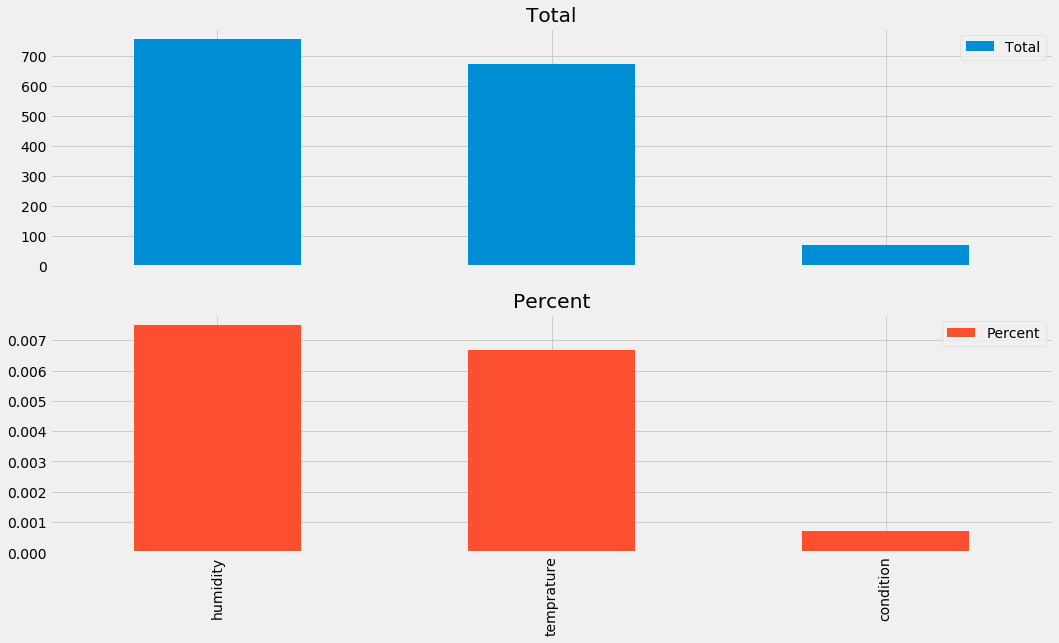

In [49]:


def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    missing_data.plot.bar(subplots=True, figsize=(16,9))

list_and_visualize_missing_data(weather_df)

In [50]:
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()

condition     0
humidity      0
temprature    0
dtype: int64

In [52]:
weather_df.describe()


,humidity,temprature
count,100990.000000,100990.000000
mean,57.957422,25.438222
std,23.821218,8.487994
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


Text(0, 0.5, 'Percent')

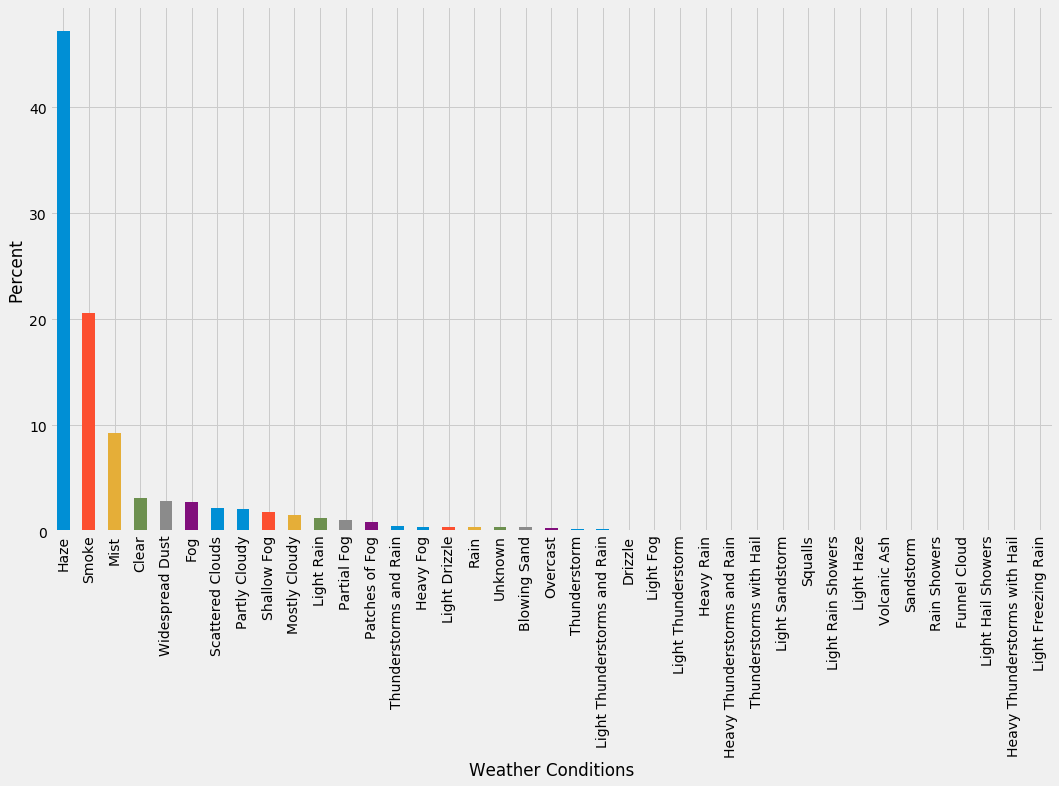

In [53]:
weather_condition = (weather_df.condition.value_counts()/(weather_df.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12548f390>,
      dtype=object)

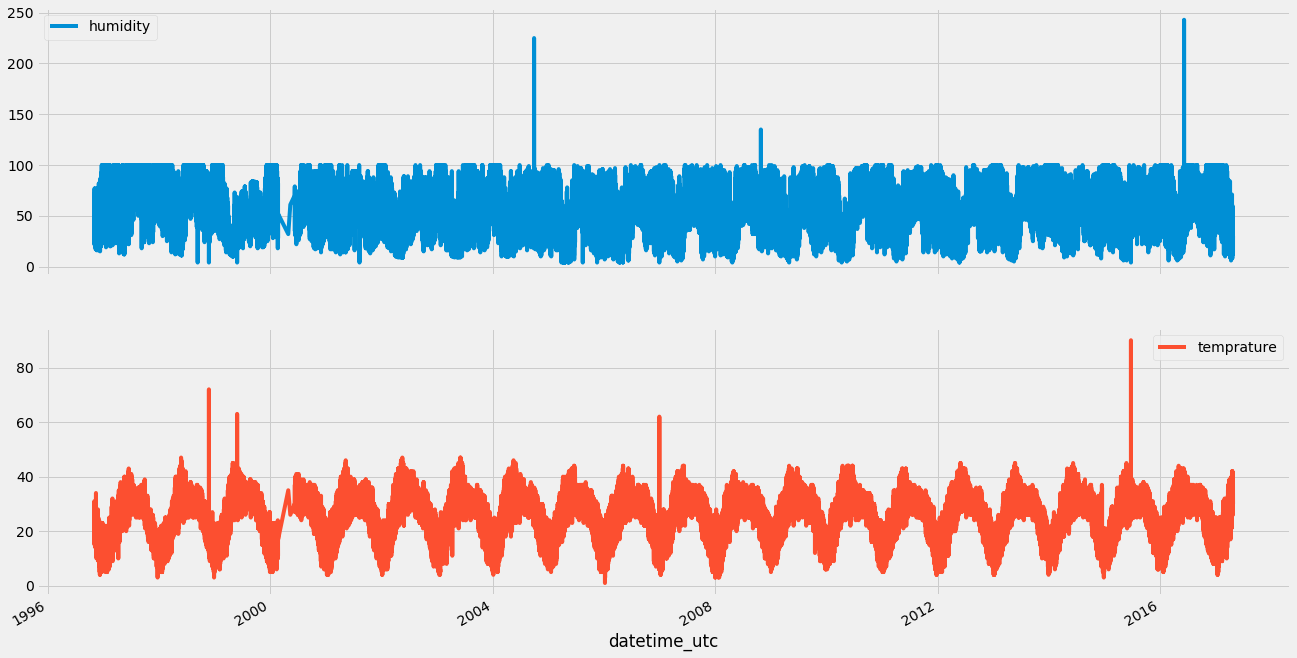

In [55]:
weather_df.plot(subplots=True, figsize=(20,12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12eebb2e8>,
      dtype=object)

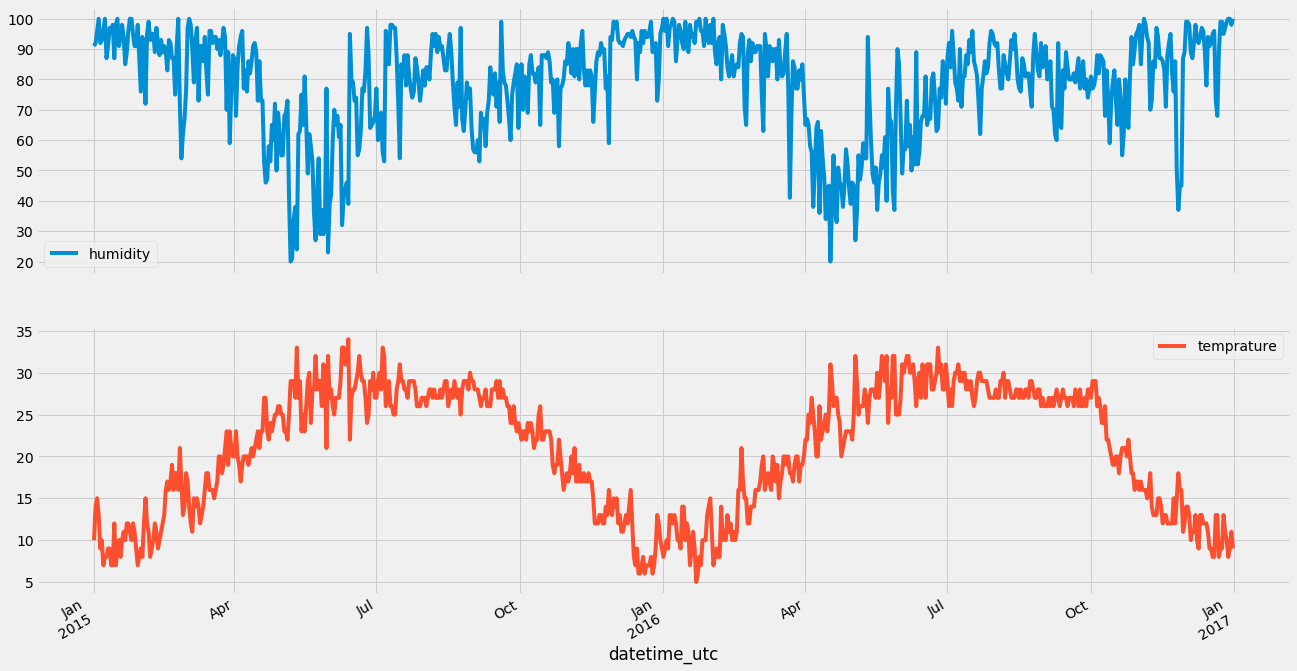

In [61]:
weather_df['2015':'2016'].asfreq('D', method='pad').resample('D').mean().plot(subplots=True, figsize=(20,12))

In [62]:
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()


In [63]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

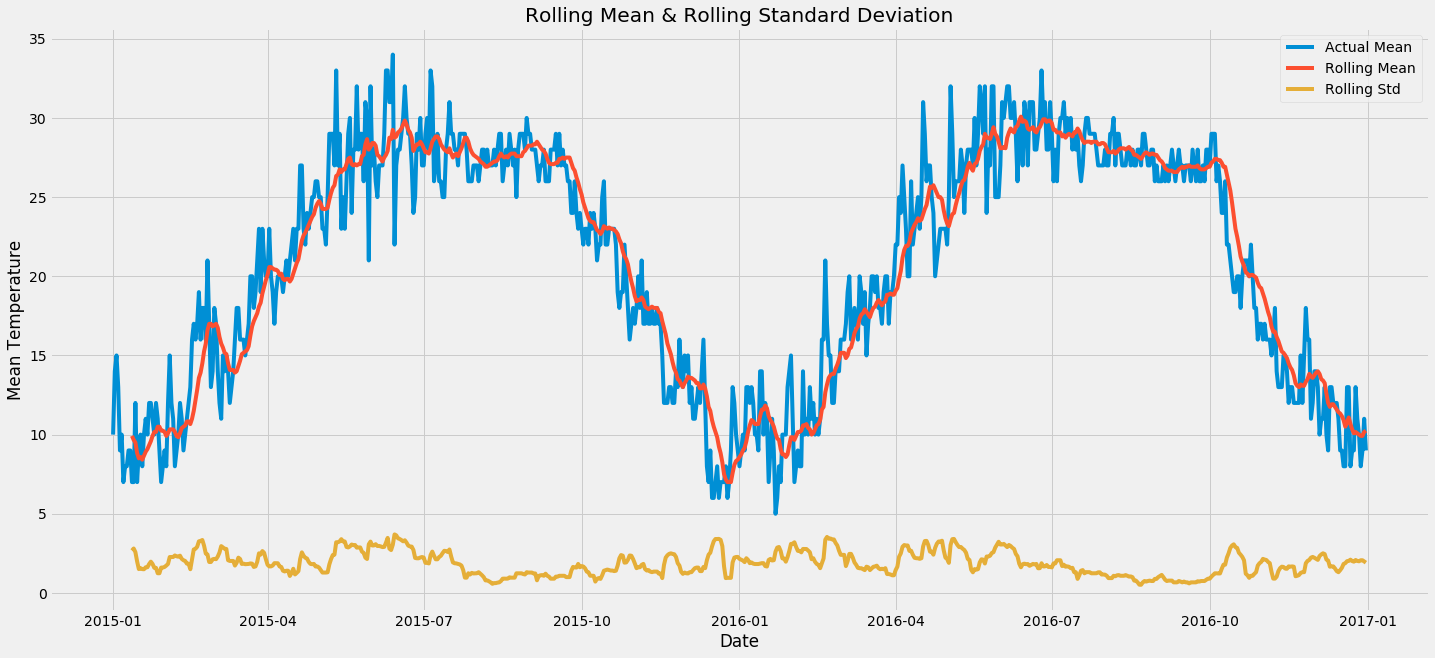

Test statistic:  -1.3894023721873967
Critical Values: {'1%': -3.4394522667904153, '5%': -2.8655569894909805, '10%': -2.568909106765338}


In [64]:
weather_ts_resampled = weather_df['2015':'2016'].temprature.asfreq('D', method='pad').resample('D').mean()
plot_rolling_mean_std(weather_ts_resampled)
perform_dickey_fuller_test(weather_ts_resampled)

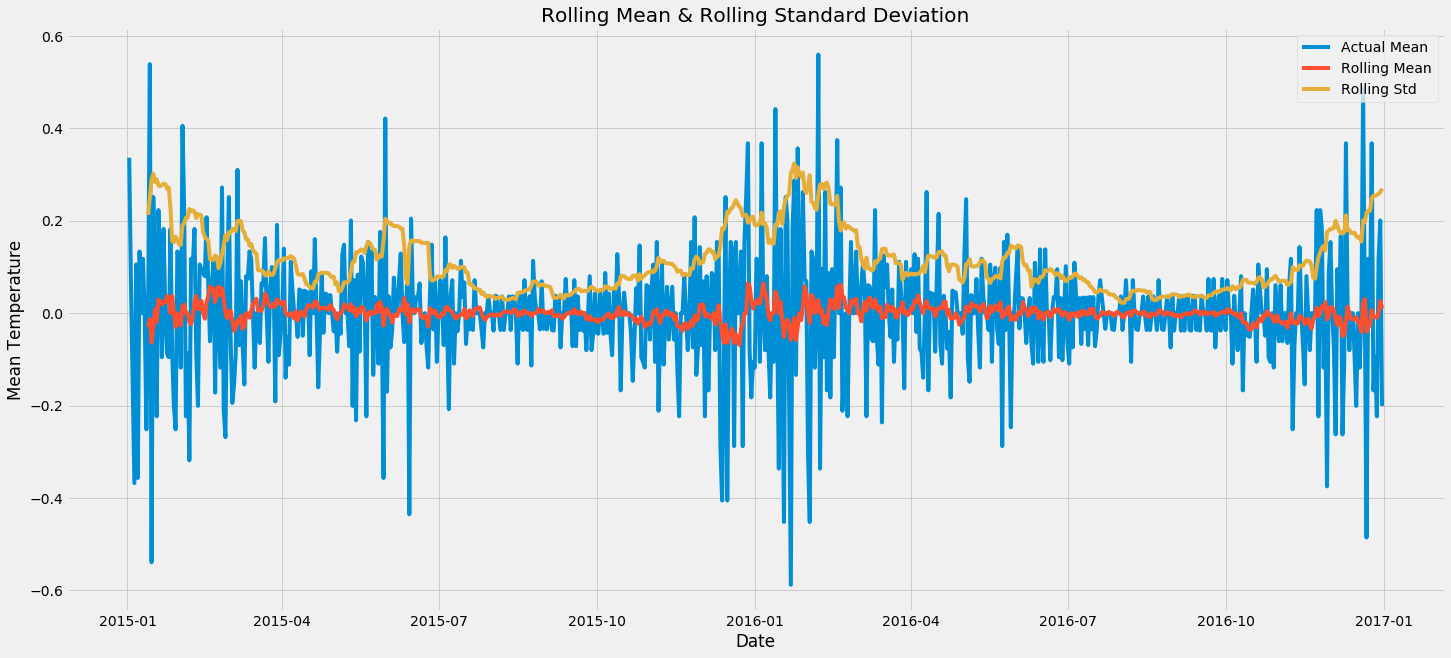

Test statistic:  -12.786977236777663
Critical Values: {'1%': -3.4394522667904153, '5%': -2.8655569894909805, '10%': -2.568909106765338}


In [65]:
weather_ts_resampled_log = np.log(weather_ts_resampled)
weather_ts_resampled_log_stationary = weather_ts_resampled_log - weather_ts_resampled_log.shift()
# due to shifting there is one NaN value
weather_ts_resampled_log_stationary.dropna(inplace=True)

plot_rolling_mean_std(weather_ts_resampled_log_stationary)
perform_dickey_fuller_test(weather_ts_resampled_log_stationary)

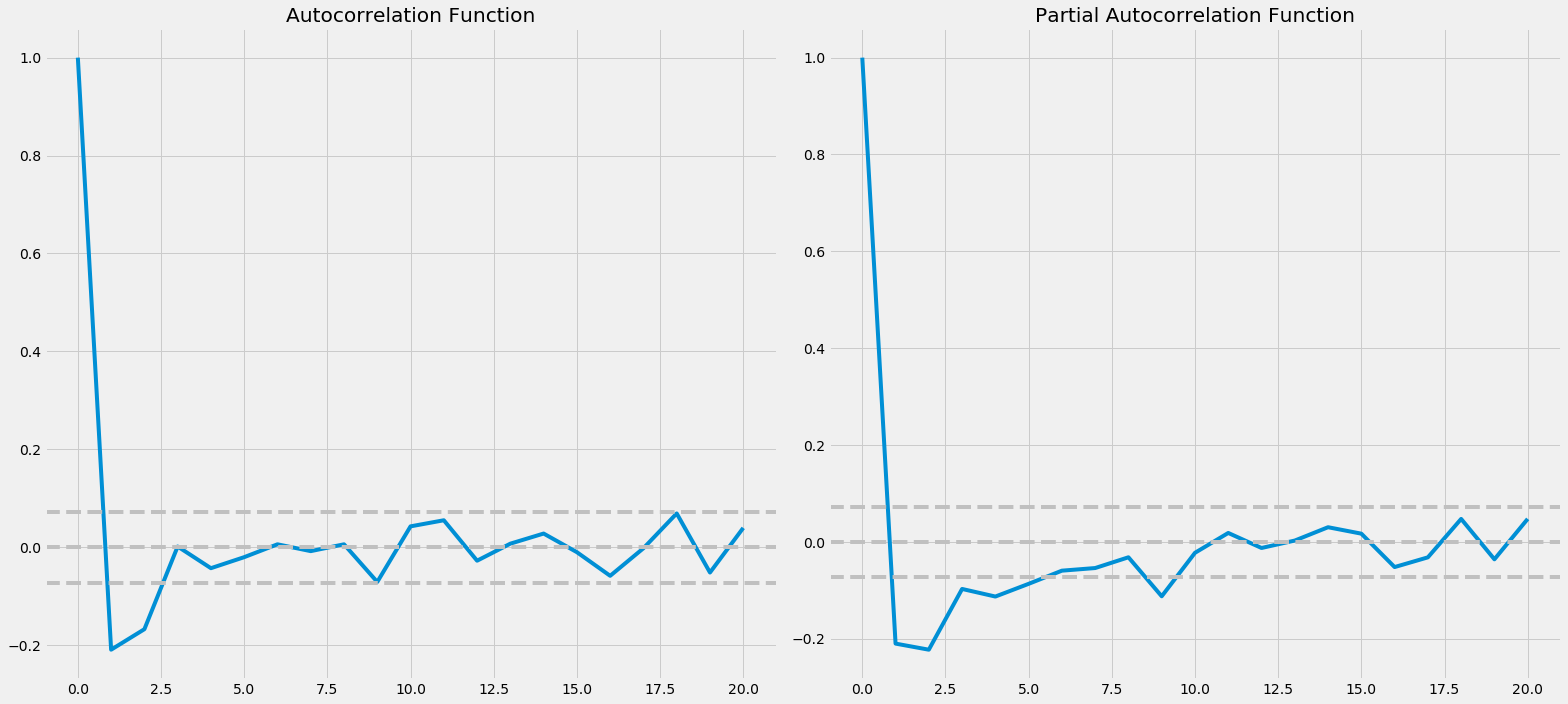

In [66]:
acf_lag = acf(weather_ts_resampled_log_stationary, nlags=20)
pacf_lag = pacf(weather_ts_resampled_log_stationary, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(weather_ts_resampled_log_stationary)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(weather_ts_resampled_log_stationary)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(weather_ts_resampled_log_stationary)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(weather_ts_resampled_log_stationary)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

AR Model RSS Score - 11.688250696550991
AR Model RMSE - 0.126535774878263


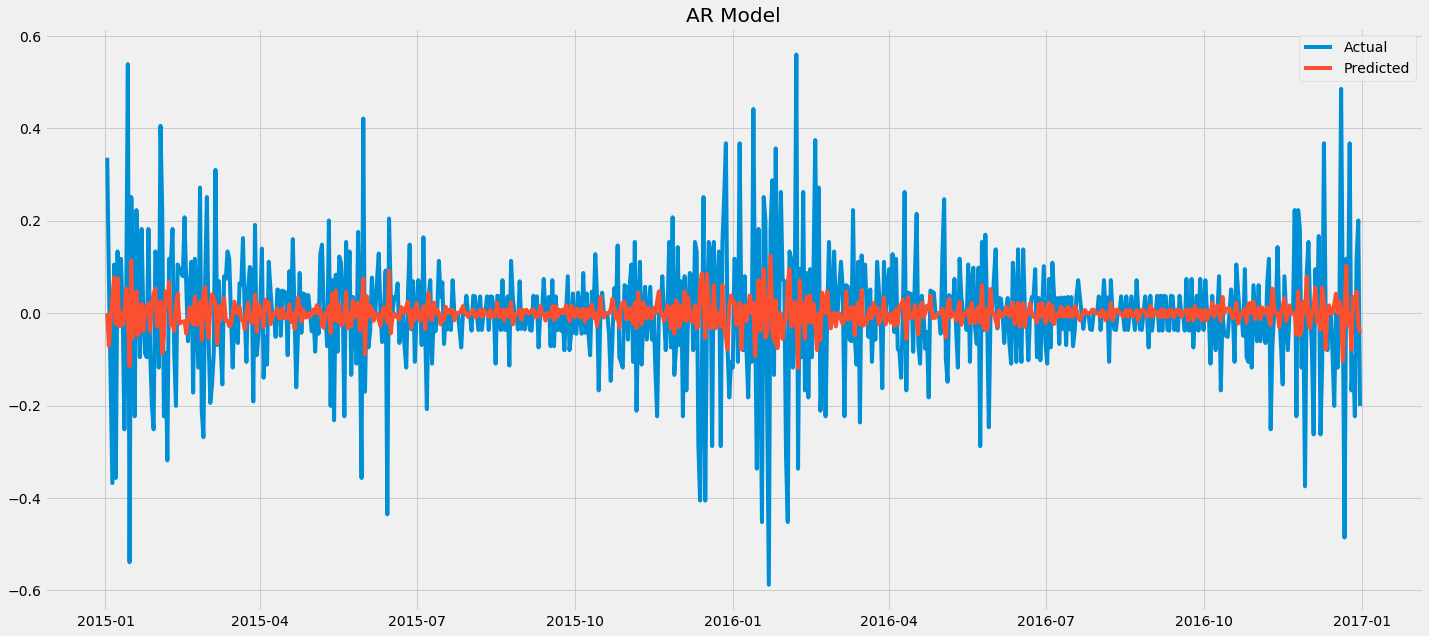

In [67]:
model = ARIMA(weather_ts_resampled_log_stationary, order=(1,0,0))
AR_model = model.fit(disp=1)
print(f'AR Model RSS Score - {sum((AR_model.fittedvalues - weather_ts_resampled_log_stationary)**2)}')
print(f'AR Model RMSE - {np.sqrt(sum((AR_model.fittedvalues-weather_ts_resampled_log_stationary)**2)/len(weather_ts_resampled_log_stationary))}')
plt.figure(figsize=(22,10))
plt.plot(weather_ts_resampled_log_stationary, label='Actual')
plt.plot(AR_model.fittedvalues, label='Predicted')
plt.title('AR Model')
plt.legend()
plt.show()

In [68]:
ARIMA_predictions = pd.Series(ARIMA_model.fittedvalues, copy=True)
ARIMA_predictions.head()

NameError: name 'ARIMA_model' is not defined

In [69]:
final_ARIMA_predictions = np.exp(ARIMA_predictions_inverse_difference)
plt.figure(figsize=(22,10))
actual_values = weather_ts_resampled.drop(missing_keys.values)
plt.plot(actual_values, label='Actual')
plt.plot(final_ARIMA_predictions, label='Prediction')
plt.title(f'RMSE - {np.sqrt(sum((final_ARIMA_predictions-actual_values)**2)/len(actual_values))}')
plt.legend()
plt.show()

NameError: name 'ARIMA_predictions_inverse_difference' is not defined